# Example geographic IMD analysis

This is a sample notebook for doing an analysis of some Index of Multiple Deprivation data (IMD)
and plotting the results in python. The structure of this notebook reflects the tasks in this order:

  - Choose the area to look at. Most analysts will want a specific geographic area covering a city or NHS Trust, and not doing the whole country can speed up rendering.
  - Get the LSOA geographic data (boundary polygons) from the ONS.
    - You probably want 2011 data. Even though the 2021 census is done, the 2019 IMD data is the most recent 
      IMD data. ANd the 2019 IMD data is linked to 2011 census LSOA regions.
  - Decide whether you want:
    - All LSOAs entirely contained in the original area
    - All LSOAs even partially contained in the original area. 
      In this case our map boundary should expand to be the limits of these LSOAs
  - Find the set of all LSOAs identifiers meeting the decision above.
  - Get the [IMD data from the ONS](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019)
     - You probably want 2019 data (most recent) and File 7 (All Scores, ranks and deciles by LSOA in CSV format)
       For more detailed investigations you might want  the underlying indicators (File 8)
  - Choose which IMD data you want to plot, and produce a Geopandas dataframe with the LSOA id, your data, and the polygons
    - This may be the raw data from a column, or you might want to transform it some way. For example, you might want a measure like "IMD excluding health outcomes" so you don't end up with a feedback loop
  - Choose a plotting colour scheme (eg shades of red - blue by)
  - Plot a Folium map for the area chosen in steps 1 & 3
  - Overlay the Folium map with relevant LSOA polygons with boundaries and fill appropriately coloured
  - Possibly add pins or mouseovers with details like LSOA name, measure name and measure value.



In [183]:
# Python imports
import palettable
import folium
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import urllib.request


In [184]:
# Global variables
cache_path = os.path.join(os.getcwd(), "cache") # path for downloading data to

def fetch(url, relative_path):
    """If a file has already been downloaded, fetch it from the cache, otherwise download it. Returns a path to
       the downloaded data"""
    if not os.path.exists(cache_path):
        os.makedirs(cache_path)
    file_path = os.path.join(cache_path, relative_path)
    if not os.path.exists(file_path):
        urllib.request.urlretrieve(url, file_path)
    return file_path

## Choose the area to look at

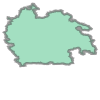

In [185]:
# In the end we want to end up with a Shape in Lat long format in a variable called area_boundary

# In this example I will get the boundary for an integrated care board from the Open Geography portal
# https://geoportal.statistics.gov.uk/datasets/ons::integrated-care-boards-april-2023-en-bfc-2/explore

def load_icb(icb):
    # URL comes from Open geography portal
    url = "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Integrated_Care_Boards_April_2023_EN_BFC/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
    icb_boundaries_path = fetch(url, "icb_boundaries.json")
    # Read the data, filtering for improved efficiency
    icb_boundaries = gpd.read_file(icb_boundaries_path, where="ICB23CD='" + icb + "'")
    # Geometry comes in BNG projection.
    icb_boundaries.set_crs("EPSG:4326")
    return icb_boundaries['geometry'][0]

area_boundary = load_icb("E54000044") # NHS Buckinghamshire, Oxfordshire and Berkshire ICB
area_boundary

## Get the LSOA Geographic Data

In [186]:
# Download from the Open Geography Portal at 
# https://geoportal.statistics.gov.uk/datasets/ons::lsoa-dec-2011-boundaries-generalised-clipped-bgc-ew-v3-2/explore
def load_lsoa():
    # The API address would be the URL below, but it limits to 2000 rows.
    # url = "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/LSOA_Dec_2011_Boundaries_Generalised_Clipped_BGC_EW_V3/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
    # So you have 3 options. (1) Get 2000 at a time and iterate
    # (2) Download the whole set using the browser, and see the URL. The trouble is this has a timestamp and will
    # probably expire. You can update the link by going to the geoportal, clicking download, clicking Geojson, and then seeing what
    # URL it downloads from (or just manually copy the downloaded file over)
    # (3) Find someone else who has downloaded the data, and re-use it.
    
    # In this notebook I'll go with option 2. You may need to update the URL yourself it is has expired
    url = "https://stg-arcgisazurecdataprod1.az.arcgis.com/exportfiles-1559-19700/LSOA_Dec_2011_Boundaries_Generalised_Clipped_BGC_EW_V3_2838119129839044524.zip?sv=2018-03-28&sr=b&sig=T3bTV4NIuQUTNsPAvMgeu9127T6a%2FHNEGqZCWO%2B4C0s%3D&se=2023-07-21T14%3A30%3A12Z&sp=r"
    lsoa_path = fetch(url, 'lsoa_boundaries_2011.shp.zip')    
    lsoa_gdf = gpd.read_file(lsoa_path)
    # WGS 84 lat long is CRS EPSG:4326
    # British national grid is CRS EPSG:27700
    lsoa_gdf.set_crs("EPSG:27700")
    return lsoa_gdf

lsoa_gdf = load_lsoa()
lsoa_gdf

LSOA11CD                   LSOA11NM                  LSOA11NMW  \
0      E01000001        City of London 001A        City of London 001A   
1      E01000002        City of London 001B        City of London 001B   
2      E01000003        City of London 001C        City of London 001C   
3      E01000005        City of London 001E        City of London 001E   
4      E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   
...          ...                        ...                        ...   
34748  W01001954               Cardiff 006F              Caerdydd 006F   
34749  W01001955               Swansea 025F              Abertawe 025F   
34750  W01001956               Swansea 023E              Abertawe 023E   
34751  W01001957               Swansea 025G              Abertawe 025G   
34752  W01001958               Swansea 025H              Abertawe 025H   

        BNG_E   BNG_N      LONG      LAT  \
0      532129  181625 -0.097060  51.5181   
1      532480  181699 -0.091970  51.5187   
2      532245  182036 -0.095230  51.5218   
3      533581  181265 -0.076280  51.5145   
4      544994  184276  0.089318  51.5388   
...       ...     ...       ...      ...   
34748  312960  180568 -3.255810  51.5173   
34749  265633  193182 -3.942370  51.6214   
34750  260583  192617 -4.015040  51.6151   
34751  265334  192555 -3.946440  51.6157   
34752  266265  192629 -3.933030  51.6166   

                                   GlobalID  \
0      283b0ead-f8fc-40b6-9a79-1ddd7e5c0758   
1      ddce266b-7825-428c-9e0a-df66b0179a55   
2      c45e358e-a794-485a-bf76-d96e5d458ea4   
3      4ddaf5e4-e47f-4312-89a0-923ffec028a6   
4      1c04702a-b662-4cfc-aab9-2c3e0f2d5e29   
...                                     ...   
34748  326f360d-8c5f-4d7e-a93a-898d8b6ab5dd   
34749  823e7ad3-5fc5-4c4b-b9d4-3e0a480058fe   
34750  7a48ad46-8b4d-4b0f-8ac8-ef2973a3a39e   
34751  1a2d08fc-992a-49c9-b07c-832930c197b8   
34752  babcf36f-90c2-4e82-a286-8398ded77ecc   

                                                geometry  
0      POLYGON ((532105.092 182011.230, 532162.491 18...  
1      POLYGON ((532634.497 181926.016, 532619.141 18...  
2      POLYGON ((532135.138 182198.131, 532158.250 18...  
3      POLYGON ((533808.018 180767.774, 533649.037 18...  
4      POLYGON ((545122.049 184314.931, 545271.849 18...  
...                                                  ...  
34748  POLYGON ((312991.594 180980.297, 313028.406 18...  
34749  POLYGON ((265787.377 194203.553, 265873.670 19...  
34750  POLYGON ((259983.258 194978.996, 259986.609 19...  
34751  POLYGON ((265149.000 192768.000, 265220.043 19...  
34752  POLYGON ((266140.774 193217.965, 266376.570 19...  

[34753 rows x 9 columns]

## Decide which LSOAs to use
In this demonstration we'll use any LSOAs even partly in our chosen area

## Find the LSOAs matching this decision


In [195]:
# Our Boundary is in lat long. Our LSOAs are in BNG. Simplest is to convert the LSOAs. Even though this is slow, 
# we'll want them in lat long for plotting later
# lsoa_gdf = lsoa_gdf.to_crs("EPSG:4326")

# If this slow speed is prohibitive, it will be quicker to convert the area boundary to BNG, filter, then convert
# just the needed LSOAs to lat long.

area_boundary_bng_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[area_boundary])
area_boundary_bng_gdf.to_crs("EPSG:27700")
local_lsoas_gdf = lsoa_gdf[lsoa_gdf.intersects(area_boundary_bng_gdf['geometry'][0])]
local_lsoas_gdf.to_crs("EPSG:4326")

LSOA11CD            LSOA11NM           LSOA11NMW   BNG_E   BNG_N  \
2389   E01002441     Hillingdon 003D     Hillingdon 003D  506149  188827   
2390   E01002442     Hillingdon 003E     Hillingdon 003E  504803  189153   
2409   E01002461     Hillingdon 013A     Hillingdon 013A  505943  186504   
2458   E01002512     Hillingdon 013C     Hillingdon 013C  506302  184977   
2460   E01002514     Hillingdon 015C     Hillingdon 015C  505453  184605   
...          ...                 ...                 ...     ...     ...   
32602  E01033514  Milton Keynes 025E  Milton Keynes 025E  482001  234712   
32604  E01033517  Milton Keynes 025G  Milton Keynes 025G  482086  234149   
32605  E01033519  Milton Keynes 028E  Milton Keynes 028E  482534  233587   
32607  E01033522  Milton Keynes 019F  Milton Keynes 019F  481141  236279   
32799  E01033724     Hillingdon 016F     Hillingdon 016F  505270  182718   

          LONG      LAT                              GlobalID  \
2389  -0.46917  51.5883  7c9f811b-0d47-49de-aef1-c67c295cc671   
2390  -0.48849  51.5915  06e1444b-7878-4ccd-a157-9b2cc6e323e1   
2409  -0.47284  51.5675  f9540f91-8311-445e-bd31-df931d78ea4b   
2458  -0.46812  51.5537  5bbd0519-3426-4cc7-a06d-bc9ef8a2f67a   
2460  -0.48047  51.5505  35a2385e-1f3e-43ff-aab0-47c69f677e61   
...        ...      ...                                   ...   
32602 -0.80680  52.0048  c9b565ad-f495-41f3-bf13-e7e3605f79b7   
32604 -0.80570  51.9997  d8c98f80-3b9f-434f-afa2-080187c62680   
32605 -0.79931  51.9946  d394fdc9-66f7-4446-bae5-b9be793491c8   
32607 -0.81896  52.0190  55931a6a-ac4d-438d-a3e7-a7e68c2d6562   
32799 -0.48368  51.5336  02b863dd-f00a-416a-b329-14bb036d1e88   

                                                geometry  
2389   POLYGON ((-0.48755 51.60347, -0.48892 51.60156...  
2390   POLYGON ((-0.49502 51.60223, -0.49113 51.59825...  
2409   POLYGON ((-0.46580 51.56277, -0.46511 51.56254...  
2458   POLYGON ((-0.45969 51.55393, -0.46058 51.55117...  
2460   POLYGON ((-0.47665 51.55468, -0.47673 51.55450...  
...                                                  ...  
32602  POLYGON ((-0.80510 52.00618, -0.80345 52.00513...  
32604  POLYGON ((-0.80412 52.00258, -0.80357 52.00176...  
32605  POLYGON ((-0.79897 52.00376, -0.79770 52.00185...  
32607  POLYGON ((-0.81373 52.02203, -0.81482 52.02020...  
32799  POLYGON ((-0.48143 51.53884, -0.48192 51.53794...  

[1157 rows x 9 columns]

## Get the IMD data from the ONS

In [196]:
imd_data_path = fetch('https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/845345/File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv', 'imd.csv')
imd_data_df = pd.read_csv(imd_data_path)
imd_data_df

LSOA code (2011)           LSOA name (2011)  \
0            E01000001        City of London 001A   
1            E01000002        City of London 001B   
2            E01000003        City of London 001C   
3            E01000005        City of London 001E   
4            E01000006  Barking and Dagenham 016A   
...                ...                        ...   
32839        E01033764             Liverpool 022E   
32840        E01033765             Liverpool 061D   
32841        E01033766             Liverpool 042G   
32842        E01033767             Liverpool 050J   
32843        E01033768             Liverpool 037F   

      Local Authority District code (2019)  \
0                                E09000001   
1                                E09000001   
2                                E09000001   
3                                E09000001   
4                                E09000002   
...                                    ...   
32839                            E08000012   
32840                            E08000012   
32841                            E08000012   
32842                            E08000012   
32843                            E08000012   

      Local Authority District name (2019)  \
0                           City of London   
1                           City of London   
2                           City of London   
3                           City of London   
4                     Barking and Dagenham   
...                                    ...   
32839                            Liverpool   
32840                            Liverpool   
32841                            Liverpool   
32842                            Liverpool   
32843                            Liverpool   

       Index of Multiple Deprivation (IMD) Score  \
0                                          6.208   
1                                          5.143   
2                                         19.402   
3                                         28.652   
4                                         19.837   
...                                          ...   
32839                                     74.468   
32840                                     59.599   
32841                                     21.895   
32842                                     66.704   
32843                                     52.286   

       Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)  \
0                                                  29199                     
1                                                  30379                     
2                                                  14915                     
3                                                   8678                     
4                                                  14486                     
...                                                  ...                     
32839                                                116                     
32840                                                945                     
32841                                              12842                     
32842                                                422                     
32843                                               1833                     

       Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)  \
0                                                      9                                    
1                                                     10                                    
2                                                      5                                    
3                                                      3                                    
4                                                      5                                    
...                                                  ...                                    
32839                                             

## Decide what data to plot
For this analysis, we'll provide code for two examples, a simple one, and a more complicated one.
For the simple example we'll just do IMD Decile.
For the more complicated example, we'll calculate the IMD Score excluding health data


In [197]:

def simple_analysis(local_lsoas_g, imd_data_df):
    # For the simple example, we can intersect before doing anything else
    # Join the IMD data onto the LSOA data for only the relevant LSOAs
    gdf = pd.merge(local_lsoas_gdf, imd_data_df, left_on="LSOA11CD", right_on="LSOA code (2011)")
    result = gdf[["LSOA11CD", "LSOA11NM", "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)", "geometry"]]
    result = result.rename(columns={"Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "value"})
    return result

def imd_score_without_health(local_lsoas_gdf, imd_data_df):
    """
    For more technical details of the principles of how health is removed, see the IMD technical report.
    https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/833951/IoD2019_Technical_Report.pdf
    Do not neglect to look at Appendix F (page 83) explaining the exponential transformation.
    
    We are changing stage 5 and 6 (page 20, 21) to leave out the Health domain. 
    In standard IMD, the ranks are calculated over 7 domains, then weighted as follows:
    Income Deprivation Domain 22.5%
    Employment Deprivation Domain 22.5%
    Health Deprivation and Disability Domain 13.5%
    Education, Skills and Training Deprivation Domain 13.5%
    Barriers to Housing and Services Domain 9.3%
    Crime Domain 9.3%
    Living Environment Deprivation Domain 9.3%
    
    We will use the same transformation, but leave out health, keeping the same relative weights:
    Income Deprivation Domain 22.5 / 0.865 = 26%
    Employment Deprivation Domain 22.5 = 0.865 = 26%
    Health Deprivation and Disability Domain 0.0%
    Education, Skills and Training Deprivation Domain 13.5 / 0.865 = 15.6%
    Barriers to Housing and Services Domain 9.3 / 0.865 = 10.8%
    Crime Domain 9.3 / 0.865 = 10.8%
    Living Environment Deprivation Domain 9.3 / 0.865 = 10.8%
    """
    renamed = imd_data_df.rename(columns={
        "LSOA code (2011)": "LSOA11CD",
        "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "original_imd_rank",
        "Income Rank (where 1 is most deprived)": "income_rank",
        "Employment Rank (where 1 is most deprived)": "employment_rank",
        "Education, Skills and Training Rank (where 1 is most deprived)": "edu_rank",
        "Crime Rank (where 1 is most deprived)": "crime_rank",
        "Barriers to Housing and Services Rank (where 1 is most deprived)": "barriers_rank",
        "Living Environment Rank (where 1 is most deprived)": "living_rank",
    })
    df = renamed[["LSOA11CD", 
                  "income_rank", 
                  "employment_rank", 
                  "edu_rank", 
                  "crime_rank", 
                  "barriers_rank", 
                  "living_rank",
                 "original_imd_rank",]]
    # For this example, because we are re-ranking, we need to process all LSOAs
    # in the raw data 1 is most deprived. When doing exponential distribution 1 is least deprived.
    # There are 32,844 possible ranks
    income_exp = -23.0 * np.log(1.0 -   ((32845-df['income_rank'])/32844.0) * (1.0 - math.exp(-100.0/23.0)) )
    crime_exp = -23.0 * np.log(1.0 -   ((32845-df['crime_rank'])/32844.0) * (1.0 - math.exp(-100.0/23.0)) )
    employment_exp = -23.0 * np.log(1.0 -   ((32845-df['employment_rank'])/32844.0) * (1.0 - math.exp(-100.0/23.0)) )
    edu_exp = -23.0 * np.log(1.0 -   ((32845-df['edu_rank'])/32844.0) * (1.0 - math.exp(-100.0/23.0)) )
    barriers_exp = -23.0 * np.log(1.0 -   ((32845-df['barriers_rank'])/32844.0) * (1.0 - math.exp(-100.0/23.0)) )
    living_exp = -23.0 * np.log(1.0 -   ((32845-df['living_rank'])/32844.0) * (1.0 - math.exp(-100.0/23.0)) )
    # create the weighted sum
    total_exp = 0.26 * income_exp + 0.26 * employment_exp + 0.156 * edu_exp + 0.108 * barriers_exp + 0.108 * crime_exp + 0.108 * living_exp 
    # create the new rank score, 1 as most deprived
    total_rank_decile = pd.qcut(total_exp, 10, labels = range(10,0, -1))
    df['total_rank_decile'] = total_rank_decile
    merged = pd.merge(local_lsoas_gdf, df, left_on="LSOA11CD", right_on="LSOA11CD").rename(columns={'total_rank_decile': 'value'})
    return merged[["LSOA11CD", "LSOA11NM", "value", "geometry"]]
    
#data_gdf = simple_analysis(local_lsoas_gdf, imd_data_df)
data_gdf = imd_score_without_health(local_lsoas_gdf, imd_data_df)
data_gdf

/tmp/ipykernel_1797918/925383688.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_rank_decile'] = total_rank_decile


LSOA11CD            LSOA11NM value  \
0     E01002441     Hillingdon 003D     4   
1     E01002442     Hillingdon 003E     4   
2     E01002461     Hillingdon 013A     7   
3     E01002512     Hillingdon 013C     9   
4     E01002514     Hillingdon 015C     7   
...         ...                 ...   ...   
1152  E01033514  Milton Keynes 025E     9   
1153  E01033517  Milton Keynes 025G     9   
1154  E01033519  Milton Keynes 028E     8   
1155  E01033522  Milton Keynes 019F     6   
1156  E01033724     Hillingdon 016F     8   

                                               geometry  
0     POLYGON ((-0.48755 51.60347, -0.48892 51.60156...  
1     POLYGON ((-0.49502 51.60223, -0.49113 51.59825...  
2     POLYGON ((-0.46580 51.56277, -0.46511 51.56254...  
3     POLYGON ((-0.45969 51.55393, -0.46058 51.55117...  
4     POLYGON ((-0.47665 51.55468, -0.47673 51.55450...  
...                                                 ...  
1152  POLYGON ((-0.80510 52.00618, -0.80345 52.00513...  
1153  POLYGON ((-0.80412 52.00258, -0.80357 52.00176...  
1154  POLYGON ((-0.79897 52.00376, -0.79770 52.00185...  
1155  POLYGON ((-0.81373 52.02203, -0.81482 52.02020...  
1156  POLYGON ((-0.48143 51.53884, -0.48192 51.53794...  

[1157 rows x 4 columns]

## Choose a color scheme for the Map

In [198]:
area_boundary_color = 'black'
data_colormap_string = "RdBu" # From https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=3
data_colormap_palette = palettable.colorbrewer.diverging.RdBu_10

## Plot a Folium Map with the LSOAs and tooltips

In [199]:
# Start with a basic map
minx, miny, maxx, maxy = data_gdf.total_bounds
frame = folium.Figure(width=1000, height=1000)
local_map = folium.Map(
    location=[(maxy+miny)/2, (maxx+minx)/2], tiles="cartodbpositron", zoom_start=10
).add_to(frame)

# Add the area boundary
folium.GeoJson(data=area_boundary, style_function=lambda x: {'color': area_boundary_color, 'fillOpacity': 0.0}
              ).add_to(local_map)

# Option 1
# Add the LSOA polygons using Folium Choropleth
def add_choropleth(data_gdf, local_map):
    folium.Choropleth(
        geo_data=data_gdf,
        data=data_gdf,
        columns = ['LSOA11CD', 'value'],
        key_on="feature.properties.LSOA11CD",
        legend_name='IMD Decile',
        fill_color=data_colormap_string,
        bins=[1,2,3,4,5,6,7,8,9,10]
    ).add_to(local_map)
    
    
# Option 2
# Add the LSOA Polygons using GeoJson, which allows some custom rendering
def lsoa_style(feature):
    color = data_colormap_palette.hex_colors[feature['properties']['value']-1]
    return {
        'color': color,
        'fillOpacity': 0.1,
    }

    
# Add the data doing our ouwn plotting loop for finer control
def add_custom_lsoas(data_gdf, local_map):
    tooltip = folium.features.GeoJsonTooltip(fields=['LSOA11NM', 'value'])
    folium.GeoJson(data=data_gdf.to_json(),
                    style_function=lsoa_style,
                   tooltip = tooltip
                  ).add_to(local_map)
    
#add_choropleth(data_gdf, local_map) # Use option 1
add_custom_lsoas(data_gdf, local_map) # Use option 2
frame
